In [1]:
import xarray as xr
import intake,yaml,os
import intake_esm
import matplotlib
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from dask.diagnostics import ProgressBar
import numpy as np
import datetime
import cartopy.crs as ccrs
import cartopy.feature as cf
import seaborn as sns
from scipy import stats

In [2]:
sim_year = 2021
plus_4k = False

model_name = f'xshield_run{sim_year}'
if plus_4k & (sim_year == 2021):
    model_name = model_name + '_PLUS_4K'
print(model_name)

xshield_run2021


In [6]:
# 2021
if sim_year == 2021:
    col_url = "/home/tmerlis/hackathon/catbuild/xshield_cat.json"
    if plus_4k:
        experiment_id_name = '20191020.00Z.C3072.L79x2_pire_PLUS_4K'
        dict_key = 'GLOBALFV3.20191020.00Z.C3072.L79x2_pire_PLUS_4K.processed_new'
    else:
        experiment_id_name = '20191020.00Z.C3072.L79x2_pire'
        dict_key = 'GLOBALFV3.20191020.00Z.C3072.L79x2_pire.processed'
    var_names = ['iw_coarse_C3072_1440x720', 'clt_coarse_C3072_1440x720', 'ULWRFtoa_coarse_C3072_1440x720']

# 2024
if sim_year == 2024:
    col_url = "/home/tmerlis/hackathon/catbuild/xsh24_cat.json"
    experiment_id_name = '20191020.00Z.C3072.xs24v2'
    dict_key = '20191020.00Z.C3072.xs24v2.GLOBALFV3'
    var_names = ['iw_coarse_C3072_1440x720', 'clt_coarse_C3072_1440x720', 'rlut_coarse_C3072_1440x720']
    
col = intake.open_esm_datastore(col_url)

In [7]:
ds_list = []
for var_id_name in var_names:
    print(var_id_name)
    if sim_year == 2021:
        cat = col.search(variable_id = var_id_name, experiment_id = experiment_id_name)
    else:
        cat = col.search(variable_id = var_id_name)
    dset_dict = cat.to_dataset_dict(cdf_kwargs={'chunks': {'time':5}, 'decode_times': True})
    ds = dset_dict[dict_key]
    if (var_id_name == 'rlut_coarse_C3072_1440x720'):
        ds = ds.assign(time=lambda x: x.time  + datetime.timedelta(hours=1.5))
    ds_list.append(ds)

iw_coarse_C3072_1440x720

--> The keys in the returned dictionary of datasets are constructed as follows:
	'source_id.experiment_id.member_id'


clt_coarse_C3072_1440x720

--> The keys in the returned dictionary of datasets are constructed as follows:
	'source_id.experiment_id.member_id'


ULWRFtoa_coarse_C3072_1440x720

--> The keys in the returned dictionary of datasets are constructed as follows:
	'source_id.experiment_id.member_id'


In [8]:
ds_all = xr.merge(ds_list)

In [9]:
ds_all

<xarray.Dataset> Size: 45GB
Dimensions:              (time: 3640, grid_yt_coarse: 720, bnds: 2,
                          grid_xt_coarse: 1440)
Coordinates:
  * time                 (time) object 29kB 2019-10-20 03:00:00 ... 2021-01-1...
  * grid_yt_coarse       (grid_yt_coarse) float32 3kB -89.88 -89.62 ... 89.88
    grid_yt_coarse_bnds  (grid_yt_coarse, bnds) float32 6kB dask.array<chunksize=(720, 2), meta=np.ndarray>
  * grid_xt_coarse       (grid_xt_coarse) float32 6kB 0.125 0.375 ... 359.9
    grid_xt_coarse_bnds  (grid_xt_coarse, bnds) float32 12kB dask.array<chunksize=(1440, 2), meta=np.ndarray>
    iw_coarse            (time, grid_yt_coarse, grid_xt_coarse) float32 15GB dask.array<chunksize=(5, 720, 1440), meta=np.ndarray>
    clt_coarse           (time, grid_yt_coarse, grid_xt_coarse) float32 15GB dask.array<chunksize=(5, 720, 1440), meta=np.ndarray>
    ULWRFtoa_coarse      (time, grid_yt_coarse, grid_xt_coarse) float32 15GB dask.array<chunksize=(5, 720, 1440), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    *empty*
Attributes:
    title:                           PIRE_production_202103.20191020.00Z.C307...
    grid_type:                       regular
    grid_tile:                       N/A
    code_version:                    $Name: bronx-10_performance_z1l $
    intake_esm_vars:                 ['iw_coarse_C3072_1440x720']
    intake_esm_attrs:source_id:      GLOBALFV3
    intake_esm_attrs:experiment_id:  20191020.00Z.C3072.L79x2_pire
    intake_esm_attrs:member_id:      processed
    intake_esm_attrs:variable_id:    iw_coarse_C3072_1440x720
    intake_esm_attrs:platform:       stellar_run
    intake_esm_attrs:_data_format_:  netcdf
    intake_esm_dataset_key:          GLOBALFV3.20191020.00Z.C3072.L79x2_pire....

In [10]:
ds_all = ds_all.rename({'iw_coarse':'clivi', 'clt_coarse':'clt'})
if sim_year == 2021:
    ds_all = ds_all.rename({'ULWRFtoa_coarse':'rlut'})
if sim_year == 2024:
    ds_all = ds_all.rename({'rlut_coarse':'rlut'})

In [11]:
with ProgressBar():
    ice_cld_mask = ((ds_all.clt > 99) & (ds_all.clivi > 10**(-1))).compute()

[########################################] | 100% Completed | 207.82 s


In [12]:
rlut_filter = ds_all.rlut.where(ice_cld_mask)

In [13]:
sigma = 5.67e-8
temperature = ((rlut_filter)/(sigma))**(1/4)
temperature

<xarray.DataArray 'rlut' (time: 3640, grid_yt_coarse: 720, grid_xt_coarse: 1440)> Size: 15GB
dask.array<pow, shape=(3640, 720, 1440), dtype=float32, chunksize=(5, 720, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time            (time) object 29kB 2019-10-20 03:00:00 ... 2021-01-17 00:...
  * grid_yt_coarse  (grid_yt_coarse) float32 3kB -89.88 -89.62 ... 89.62 89.88
  * grid_xt_coarse  (grid_xt_coarse) float32 6kB 0.125 0.375 ... 359.6 359.9
    clivi           (time, grid_yt_coarse, grid_xt_coarse) float32 15GB 0.000...
    clt             (time, grid_yt_coarse, grid_xt_coarse) float32 15GB 67.85...
    rlut            (time, grid_yt_coarse, grid_xt_coarse) float32 15GB 151.5...

In [14]:
ctt_mean = temperature.mean('time', skipna = True)
with ProgressBar():
    ctt_mean = ctt_mean.compute()

[########################################] | 100% Completed | 13.44 s


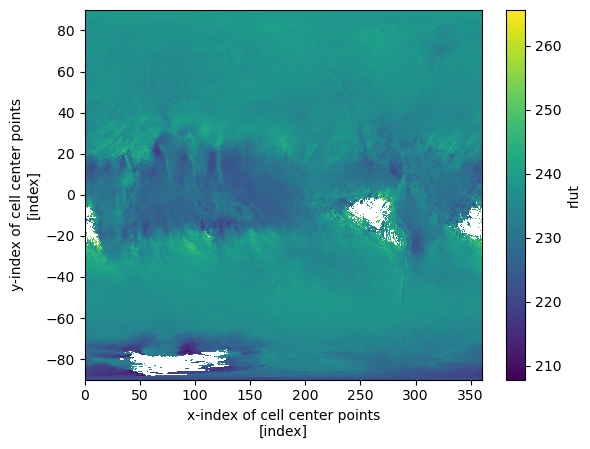

In [15]:
ctt_mean.plot()

In [16]:
# Bin CRE by latitude
lat_bins = np.arange(-90, 91, 10)
lat_binned = temperature.groupby_bins(temperature.grid_yt_coarse, bins=lat_bins)

In [17]:
def prep_lat_data_for_plots(binned, tmin = 200, tmax = 270):
    hist_data = {}
    for bin_name, bin_data in binned:
        with ProgressBar():
            bin_values = bin_data.values.flatten()
            bin_values = bin_values[~np.isnan(bin_values)]
            freq, bin_edges = np.histogram(bin_values, bins=np.arange(tmin, tmax))
            hist_data[bin_name] = (freq, bin_edges)
    return hist_data

In [18]:
hist_data = prep_lat_data_for_plots(lat_binned)

[########################################] | 100% Completed | 10.94 ss
[########################################] | 100% Completed | 10.38 ss
[########################################] | 100% Completed | 10.64 s
[########################################] | 100% Completed | 10.48 ss
[########################################] | 100% Completed | 10.48 ss
[########################################] | 100% Completed | 11.12 s
[########################################] | 100% Completed | 11.07 s
[########################################] | 100% Completed | 10.69 s
[########################################] | 100% Completed | 10.46 ss
[########################################] | 100% Completed | 9.85 sms
[########################################] | 100% Completed | 10.26 s
[########################################] | 100% Completed | 10.02 ss
[########################################] | 100% Completed | 9.66 sms
[########################################] | 100% Completed | 10.12 s
[###########

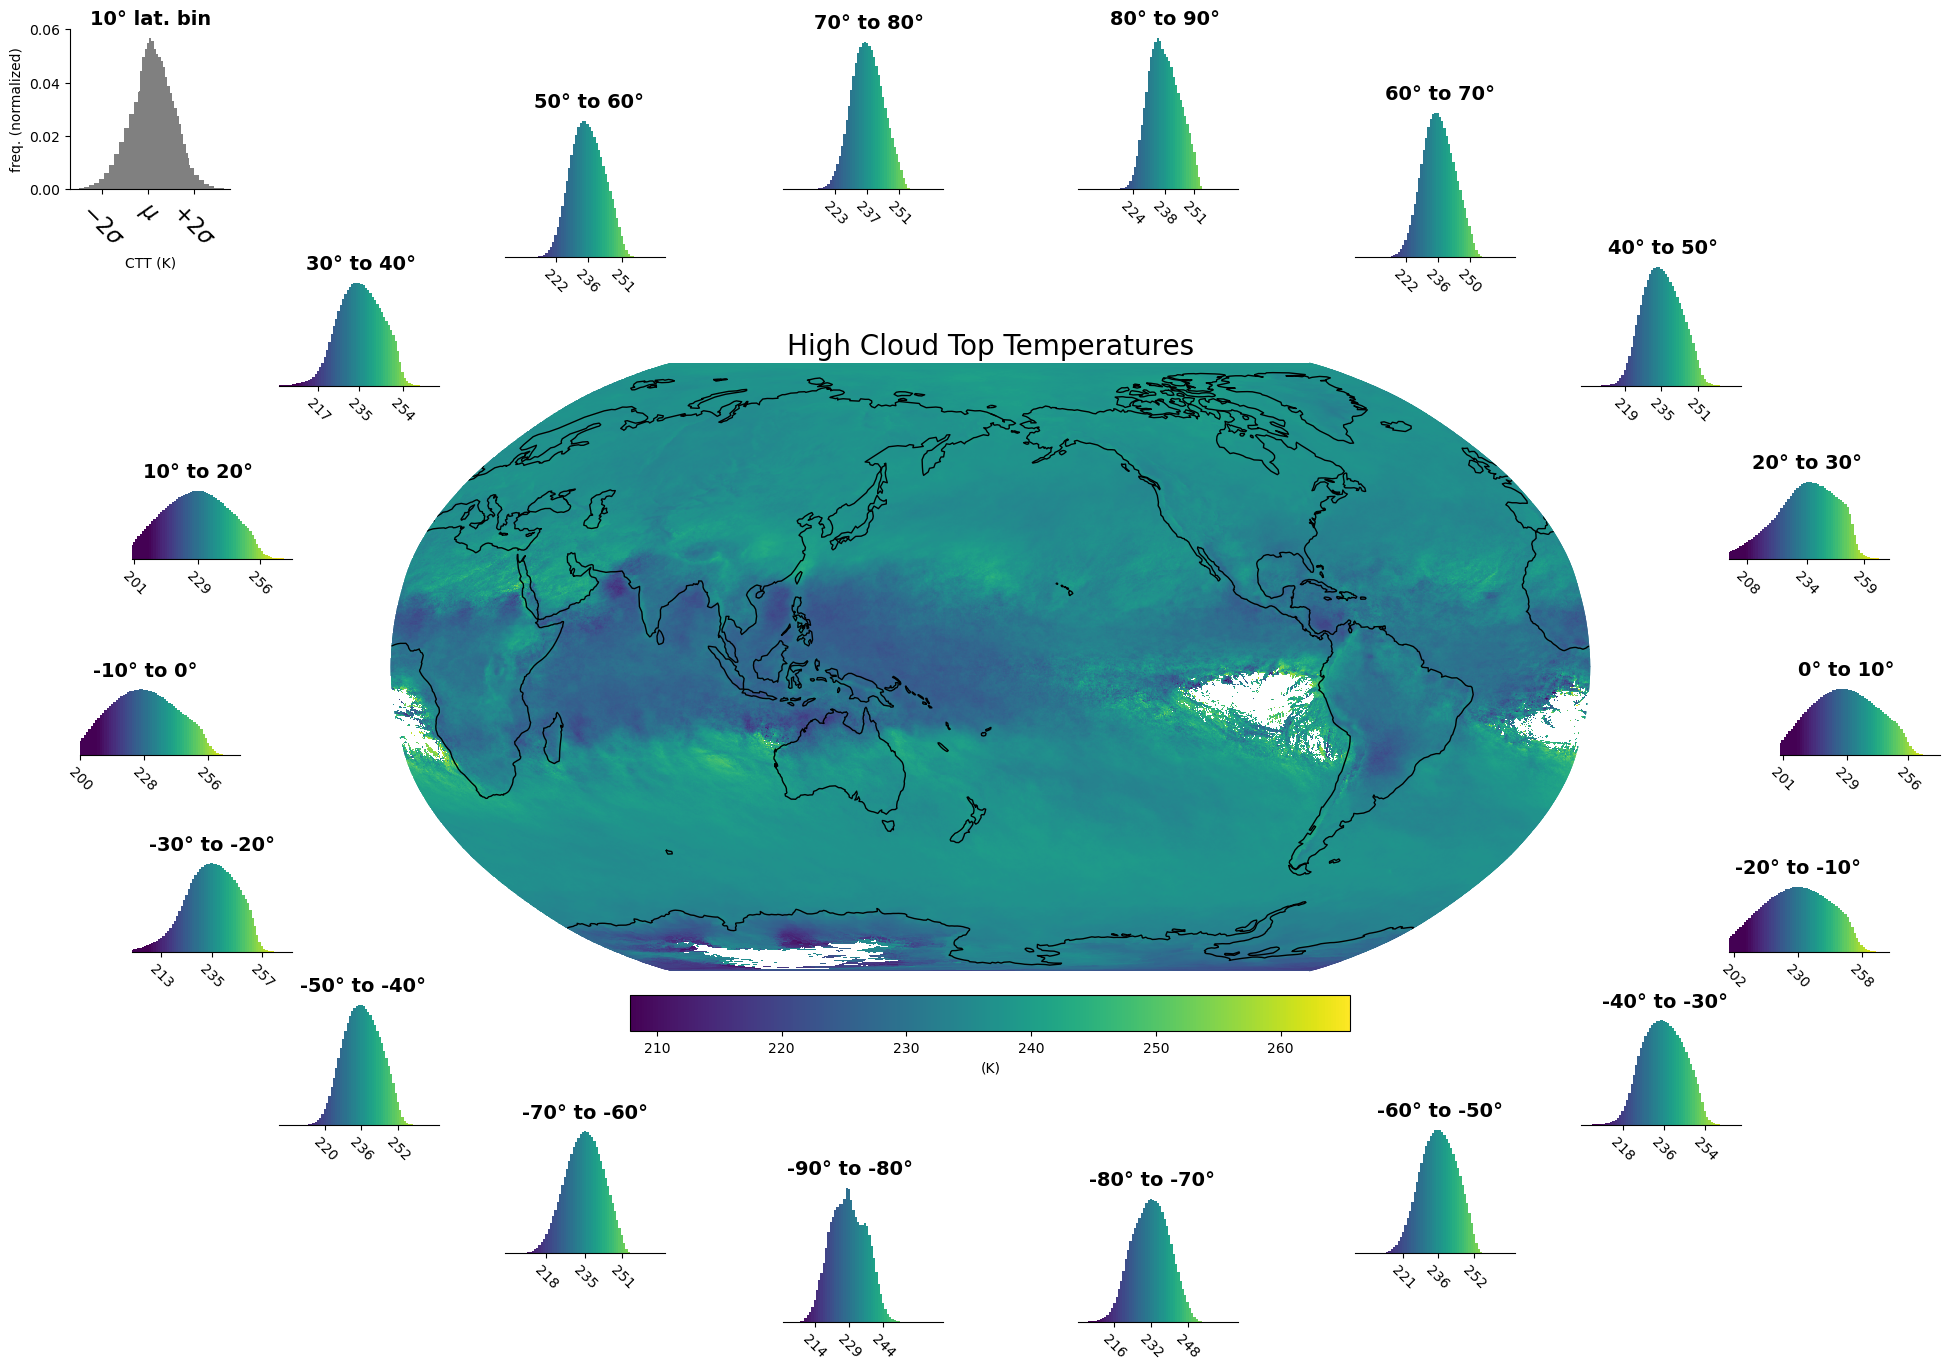

In [19]:
# create figure: map in the middle, latitudinal bins around
fig = plt.figure(figsize=(20, 20))

# Central map plot
ax_map = fig.add_axes([0.19, 0.25, 0.6, 0.6], projection=ccrs.Robinson(central_longitude=180))
ax_map.set_global()
ax_map.coastlines()

mapshow = ctt_mean.plot.pcolormesh(ax=ax_map, 
                                   transform=ccrs.PlateCarree(), 
                                   add_colorbar=False, 
                                   cmap='viridis')

cbar = plt.colorbar(mapshow, ax=ax_map, location = 'bottom', pad=0.02, shrink=0.6)
ax_map.set_title("High Cloud Top Temperatures", fontsize = 20)
cbar.set_label(label='(K)')

# Remove map axes
ax_map.axis('off')

# Get the colormap from hpshow (so we can color-code the bars later)
cmap = mapshow.get_cmap()
norm = mapshow.norm

# Calculate positions for surrounding histograms using an elliptical arrangement
# adjust these to prevent axis overlap
radius_x = 1.7  # Reduced horizontal spread
radius_y = 1.15  # Reduced vertical spread
angles = np.linspace(-np.pi, np.pi, 18, endpoint=False)
# we want the polar lats at the poles, equator at equator, etc.
reindex = np.array([4, 5, 3, 6, 2, 7, 1, 8, 0, 9, 17, 10, 16, 11, 15, 12, 14, 13])

for i, (bin_name, bin_data) in enumerate(hist_data.items()):
    freq, bin_edges = bin_data
    instances = np.sum(freq)

    bin_start, bin_end = bin_name.left, bin_name.right
    
    # Adjust angle to match latitude (reindex manually)
    lat_center = (bin_start + bin_end) / 2
    angle_adj = angles[reindex[i]]
    
    # Calculate position with elliptical adjustment
    x = radius_x * np.cos(angle_adj)
    y = radius_y * np.sin(angle_adj)
    
    # Convert to grid coordinates (0-4 range)
    x = 2 + x
    y = 2 + y
    
    # Create smaller subplot with adjusted position and size
    ax = plt.axes([x/4 - 0.04, y/4 - 0.04, 0.08, 0.08])

    # Create histogram
    n, bins, patches = ax.hist(bin_edges[:-1], bins=bin_edges, weights=freq/instances, edgecolor='None', align='left')

    # Color the histogram bars according to the central map's colormap
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    for patch, center in zip(patches, bin_centers):
        color = cmap(norm(center))
        patch.set_facecolor(color)
        
    # label the lat bin
    ax.set_xlim([200, 270])
    ax.set_ylim([0, 0.06])
    temp_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    hist_mean = np.sum(temp_centers * freq) / instances
    sigma = np.sqrt(np.sum(freq * (bin_centers - hist_mean)**2) / instances)
    two_sigma = 2*sigma
    ax.set_xticks(np.array([int(hist_mean - two_sigma), int(hist_mean), int(hist_mean + two_sigma)]))
    ax.patch.set_facecolor('none') #make transparent to help with overlapping subplots
    ax.tick_params("x", rotation=-45)
    ax.text(hist_mean, np.max(freq/instances) + 0.005, f'{bin_start:.0f}° to {bin_end:.0f}°', fontsize=14, ha='center', fontweight = 'bold')

    
    # Remove all axes, ticks and labels
    sns.despine(ax = ax)
    sns.despine(ax = ax, left = 'True')
    ax.set_yticks([], [])


## show labels
ax_legend = fig.add_axes([0.03, 0.743, 0.08, 0.08])
n, bins, patches = ax_legend.hist(bin_edges[:-1], bins=bin_edges, weights=freq/instances, edgecolor='None', align='left', color = 'grey')
N = instances
x = stats.norm.rvs(235, 10, size=N)
ax_legend.hist(x, bins=50, facecolor='grey', density = True)

ax_legend.set_xlim([200, 270])
ax_legend.set_xlabel("CTT (K)")
ax_legend.set_ylim([0, 0.06])
ax_legend.set_ylabel("freq. (normalized)")
temp_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
hist_mean = np.mean(x)
two_sigma = 20
ax_legend.set_xticks(np.array([int(hist_mean - two_sigma), int(hist_mean), int(hist_mean + two_sigma)]), labels = ['$-2\\sigma$', '$\\mu$', '$+2\\sigma$'], fontsize = 16)
ax_legend.patch.set_facecolor('none') #make transparent to help with overlapping subplots
ax_legend.tick_params("x", rotation=-45)
ax_legend.text(hist_mean, np.max(freq/instances) + 0.005, '10° lat. bin', fontsize=14, ha='center', fontweight = 'bold')

# Remove all axes, ticks and labels
sns.despine(ax = ax_legend)


plt.tight_layout()

In [20]:
np.save('hist_data_' + model_name + '.npy', hist_data) 

In [21]:
ctt_mean.to_netcdf(model_name + '_composite.nc')